In [129]:
import warnings
warnings.filterwarnings('ignore')


In [130]:
!pip install librosa soundfile pydub


In [131]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
import librosa.display
import IPython.display as ipd




 Analyzing: test1.mp3

 Segment 1


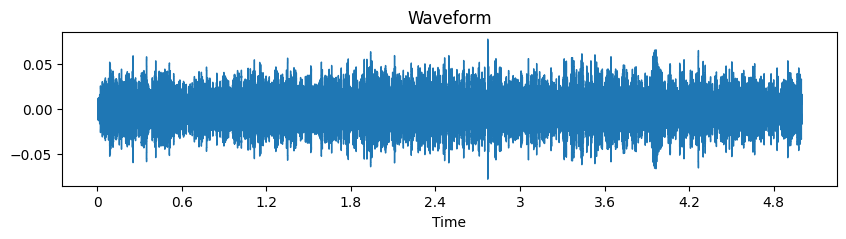

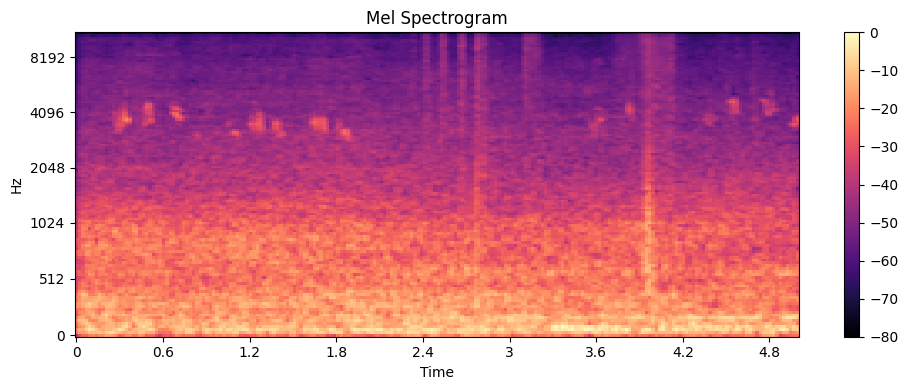

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Raw prediction vector (softmax): [0.000e+00 4.000e-04 0.000e+00 1.800e-03 0.000e+00 0.000e+00 0.000e+00
 3.000e-04 0.000e+00 0.000e+00 9.500e-02 9.025e-01]
Prediction probabilities for all species:
  - amecro: 0.0000
  - amerob: 0.0004
  - bewwre: 0.0000
  - bkcchi: 0.0018
  - daejun: 0.0000
  - houfin: 0.0000
  - houspa: 0.0000
  - norfli: 0.0003
  - rewbla: 0.0000
  - sonspa: 0.0000
  - spotow: 0.0950
  - whcspa: 0.9025


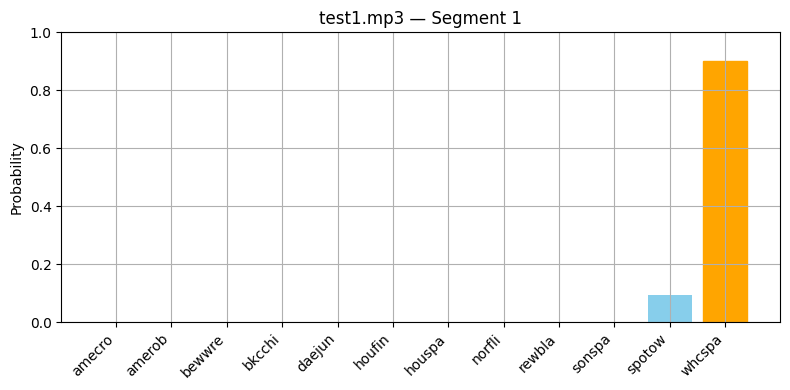


 Analyzing: test2.mp3

 Segment 1


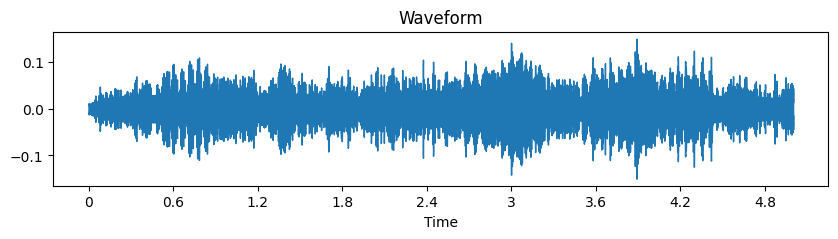

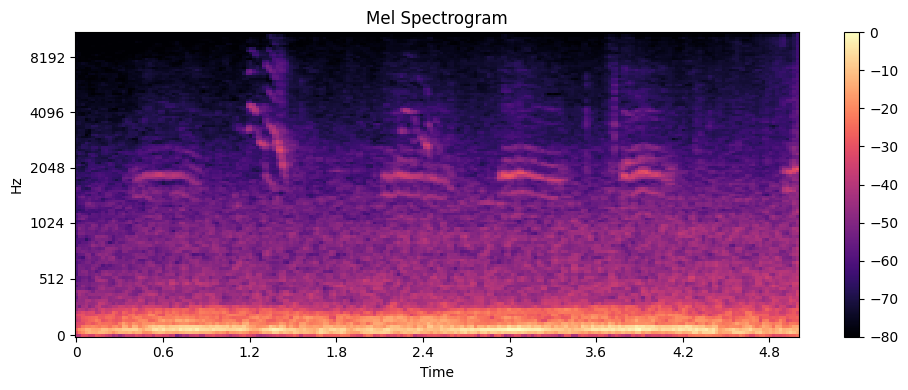

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Raw prediction vector (softmax): [0.000e+00 3.000e-04 0.000e+00 3.100e-03 0.000e+00 0.000e+00 0.000e+00
 4.000e-04 0.000e+00 0.000e+00 1.043e-01 8.919e-01]
Prediction probabilities for all species:
  - amecro: 0.0000
  - amerob: 0.0003
  - bewwre: 0.0000
  - bkcchi: 0.0031
  - daejun: 0.0000
  - houfin: 0.0000
  - houspa: 0.0000
  - norfli: 0.0004
  - rewbla: 0.0000
  - sonspa: 0.0000
  - spotow: 0.1043
  - whcspa: 0.8919


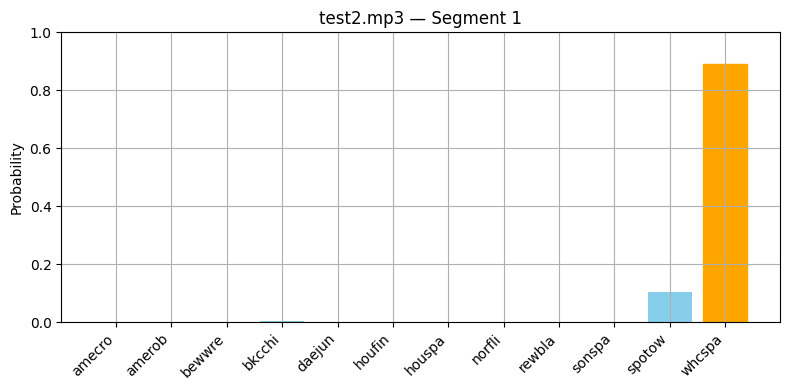


 Analyzing: test3.mp3

 Segment 1


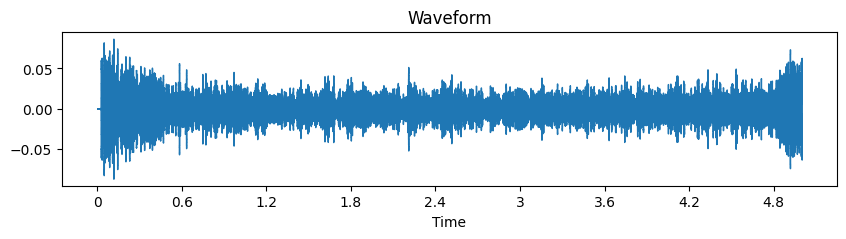

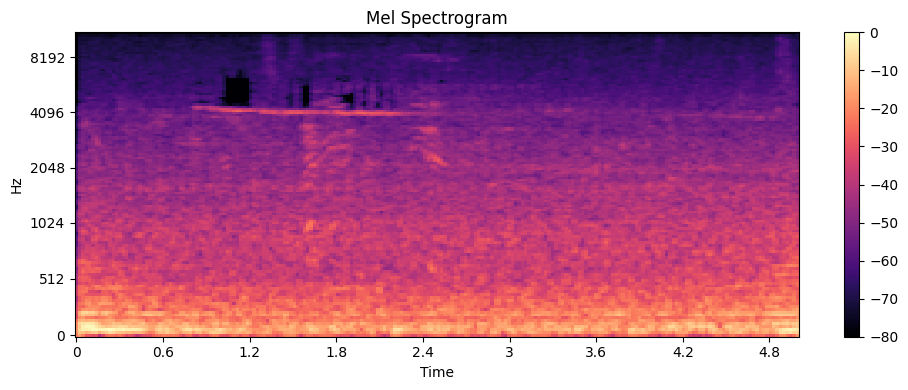

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Raw prediction vector (softmax): [0.000e+00 2.000e-04 0.000e+00 3.200e-03 0.000e+00 0.000e+00 0.000e+00
 4.000e-04 0.000e+00 0.000e+00 6.680e-02 9.294e-01]
Prediction probabilities for all species:
  - amecro: 0.0000
  - amerob: 0.0002
  - bewwre: 0.0000
  - bkcchi: 0.0032
  - daejun: 0.0000
  - houfin: 0.0000
  - houspa: 0.0000
  - norfli: 0.0004
  - rewbla: 0.0000
  - sonspa: 0.0000
  - spotow: 0.0668
  - whcspa: 0.9294


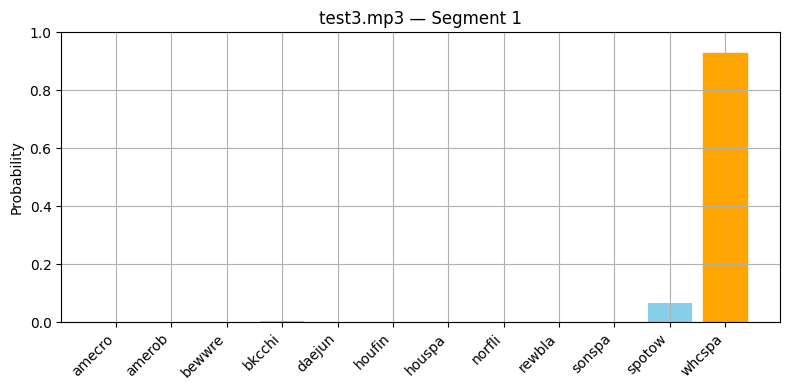

In [ ]:


# === Load model and class names ===
model = load_model("results/model/my_multiclass_cnn_model.h5")
class_names = np.load("PreprocessData/preprocessed_birds.npz")["class_names"]
class_names = [name.decode() if isinstance(name, bytes) else name for name in class_names]

# === Segment extraction ===
def extract_segments(file_path, sr=22050, duration=5.0, max_segments=3):
    y, sr = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=20)
    segments = []
    for start, end in intervals:
        seg = y[start:end]
        if librosa.get_duration(y=seg, sr=sr) >= duration:
            seg = librosa.util.fix_length(seg, size=int(sr * duration))
            segments.append(seg)
        if len(segments) >= max_segments:
            break
    return segments

# === Spectrogram conversion ===
def to_spectrogram(segment, sr=22050, shape=(128, 517)):
    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=shape[0])
    S_dB = librosa.power_to_db(S, ref=np.max)
    S_D_B = (S_dB - np.mean(S_dB)) / (np.std(S_dB) + 1e-6)
    padded = np.zeros(shape)
    w = min(S_D_B.shape[1], shape[1])
    padded[:, :w] = S_D_B[:, :w]
    return padded[np.newaxis, :, :, np.newaxis]

# === Visualize waveform and spectrogram ===
def visualize(segment, sr=22050):
    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(segment, sr=sr)
    plt.title("Waveform")
    plt.show()

    S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

# === Plot probabilities ===
def plot_prediction_bar(probabilities, class_names, title=""):
    plt.figure(figsize=(8, 4))
    bars = plt.bar(class_names, probabilities, color='skyblue')
    top_idx = np.argmax(probabilities)
    bars[top_idx].set_color('orange')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.title(title)
    plt.tight_layout()
    plt.grid()
    plt.show()

# === Full Debug Pipeline ===
def debug_clip(file_path):
    print(f"\n Analyzing: {file_path}")
    segments = extract_segments(file_path)
    if not segments:
        print("No valid segments found.")
        return

    for i, segment in enumerate(segments):
        print(f"\n Segment {i+1}")
        ipd.display(ipd.Audio(segment, rate=22050))
        visualize(segment)
        
        X = to_spectrogram(segment)
        pred = model.predict(X)[0]
        
        print("Raw prediction vector (softmax):", np.round(pred, 4))
        print("Prediction probabilities for all species:")
        for idx, prob in enumerate(pred):
            print(f"  - {class_names[idx]}: {prob:.4f}")
        
        plot_prediction_bar(pred, class_names, title=f"{file_path} — Segment {i+1}")

# === Run on test clips ===
test_files = ["test1.mp3", "test2.mp3", "test3.mp3"]
for file in test_files:
    debug_clip(file)
